In [1]:
# Import packages
import os

import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Download data
et.data.get_data('spatial-vector-lidar')

# Set working directory
working_dir = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if not os.path.exists(working_dir):
    print('Working directory {} does not exist. Creating...'
          .format(working_dir))
    os.makedirs(working_dir)

os.chdir(working_dir)
print('Working directory changed to {}'.format(working_dir))

Working directory changed to /Users/elsa/earth-analytics/data


In [3]:
%%bash
find spatial-vector-lidar/california

spatial-vector-lidar/california
spatial-vector-lidar/california/madera-county-roads
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shx
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shp
spatial-vector-lidar/california/madera-county-roads/tl_2010_05143_roads.shp.xml
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.dbf
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shp.xml
spatial-vector-lidar/california/madera-county-roads/metadata.html
spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.prj
spatial-vector-lidar/california/neon-sjer-site
spatial-vector-lidar/california/neon-sjer-site/2013
spatial-vector-lidar/california/neon-sjer-site/2013/insitu
spatial-vector-lidar/california/neon-sjer-site/2013/insitu/veg_metadata_desc_DataInstitute2016.csv
spatial-vector-lidar/california/neon-sjer-site/2013/insitu/veg_chemistry
spatial-vector-lidar/california/neon-sjer-site/2013/insi

In [4]:
# Set California data path
ca_path = os.path.join(
    'spatial-vector-lidar', 'california')
sjer_vector_path = os.path.join(
    ca_path, 'neon-sjer-site', 'vector_data')

# Set Madera County Roads path
madera_roads_path = os.path.join(
    ca_path, 'madera-county-roads', 'tl_2013_06039_roads.shp')

# Set SJER site centroids path
sjer_sites_path = os.path.join(
    sjer_vector_path, 'SJER_plot_centroids.shp')

# Set SJER area of interest path
sjer_aoi_path = os.path.join(
    sjer_vector_path, 'SJER_crop.shp')

# Set California Counties path
ca_counties_path = os.path.join(
    ca_path, 'CA_Counties', 'CA_Counties_TIGER2016.shp')

# Set California Roads path
ww_roads_path = os.path.join(
    'spatial-vector-lidar', 'global', 'ne_10m_roads', 'ne_10m_roads.shp')

path_list = [
    madera_roads_path, sjer_sites_path, 
    sjer_aoi_path, ca_counties_path]

for pth in path_list:
    if os.path.exists(pth):
        print('{} exists'.format(pth))
    else:
        print('{} does not exist.'.format(pth))

spatial-vector-lidar/california/madera-county-roads/tl_2013_06039_roads.shp exists
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_plot_centroids.shp exists
spatial-vector-lidar/california/neon-sjer-site/vector_data/SJER_crop.shp exists
spatial-vector-lidar/california/CA_Counties/CA_Counties_TIGER2016.shp exists


In [5]:
# Import data to GeoDataFrames
madera_roads_full_gdf = gpd.read_file(madera_roads_path)

# Locate NA rows
na_rows = ~madera_roads_full_gdf.RTTYP.isin(['M', 'S', 'C'])
madera_roads_full_gdf.loc[na_rows, 'RTTYP'] = 'Unknown'
madera_roads_full_gdf.RTTYP.unique()

array(['M', 'Unknown', 'S', 'C'], dtype=object)

In [6]:
sjer_sites_full_gdf = gpd.read_file(sjer_sites_path)

<AxesSubplot:>

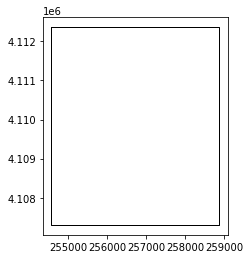

In [7]:
sjer_aoi_gdf = gpd.read_file(sjer_aoi_path)
sjer_aoi_gdf.plot(facecolor='none')

<AxesSubplot:>

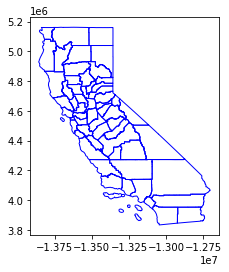

In [8]:
ca_counties_gdf = gpd.read_file(ca_counties_path)
ca_counties_gdf.plot(facecolor='none', edgecolor='blue')

In [9]:
ww_roads_gdf = gpd.read_file(ww_roads_path)

In [10]:
# Set CRSs to match
madera_roads_full_gdf = madera_roads_full_gdf.to_crs(sjer_aoi_gdf.crs)

if all([gdf.crs==sjer_aoi_gdf.crs 
        for gdf 
        in [madera_roads_full_gdf, sjer_sites_full_gdf]]):
    print('All CRSs match!')

All CRSs match!


<AxesSubplot:>

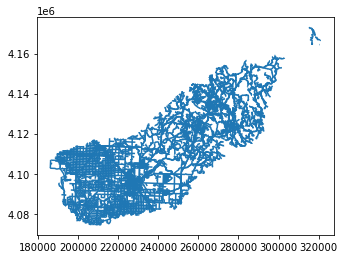

In [11]:
madera_roads_full_gdf.plot()

<AxesSubplot:>

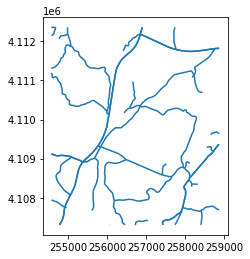

In [12]:
madera_roads_gdf = madera_roads_full_gdf.clip(sjer_aoi_gdf)
madera_roads_gdf.plot()

<AxesSubplot:>

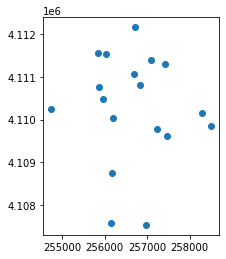

In [13]:
sjer_sites_full_gdf.plot()

<AxesSubplot:>

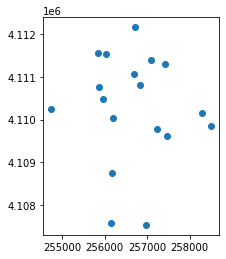

In [14]:
sjer_sites_gdf = sjer_sites_full_gdf.clip(sjer_aoi_gdf)
sjer_sites_gdf.plot()

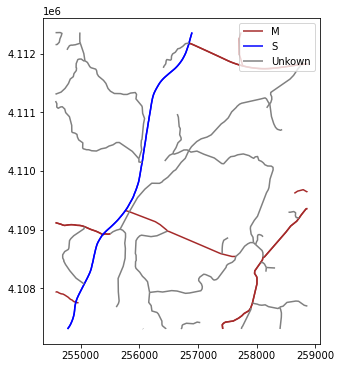

In [15]:
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Add road layers to plot
road_color_dict = {
    'M': 'brown',
    'S': 'blue',
    'Unknown': 'grey'}
road_type_dict = {
    'M': 'M',
    'S': 'S',
    'Unknown': 'Unkown'}

for rttyp, gdf in madera_roads_gdf.groupby('RTTYP'):
    gdf.plot(ax=ax, color=road_color_dict[rttyp], label=road_type_dict[rttyp])
    
ax.legend()

<AxesSubplot:>

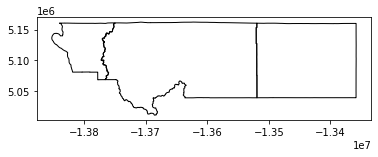

In [16]:
three_counties_gdf = (
    ca_counties_gdf
    [ca_counties_gdf.NAME.isin(['Del Norte', 'Modoc', 'Siskiyou'])])
three_counties_gdf.plot(facecolor="none")

In [17]:
three_counties_reproj_gdf = three_counties_gdf.to_crs(ww_roads_gdf.crs)
roads_by_county_gdf = three_counties_reproj_gdf.sjoin(
    ww_roads_gdf, how='inner', predicate='intersects')